'가까운공원ID',

In [1]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

from backup.module.preprocess import drop_columns

fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'AppleGothic'}) # 폰트 설정
plt.rc('font', family='AppleGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance

In [2]:
# sys.path를 수정하여 모듈 경로를 설정
import sys
import os
import pandas as pd

# 프로젝트 루트 경로 추가
project_root = os.path.abspath("..")
sys.path.append(project_root)
# 모든 컬럼 출력 설정
# pd.set_option('display.max_columns', None)
# 모든 행 출력 설정
# pd.set_option('display.max_rows', None)

import module

In [3]:
df, df_test_y = module.file_load.load_current_version()

In [4]:
df['is_test'].value_counts()      # train과 test data가 하나로 합쳐진 것을 확인할 수 있습니다.

is_test
0    1097155
1       5607
Name: count, dtype: int64

In [6]:
# 결측치가 많거나 필요 없는 컬럼을 정리한다
drop_columns = [
    'index', '시군구',  '본번', '부번',
      '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지',
       'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)',
       'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)',
       'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적',
       'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하',
       'k-135㎡초과', 'k-홈페이지', 'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태',
       '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일',
       '사용허가여부', '관리비 업로드','단지신청일', '금리_단기1년전차이',
       'nearest_subway_distance', 'nearest_bus_distance', '1차역세권', '2차역세권',
       '1차버스정류장', '경과연도', '경과구분',  '층_그룹', '평수_그룹', '시',
       '아파트ID', '아파트ID거리', 'nearest_park_distance', '가까운공원이름', 
       '공원갯수', '공원총면적', '공원생활권점수', '산책로갯수', '산책로총길이', '산책생활권점수', '생태문화길갯수',
       '생태문화길총길이', '생태문화생활권점수', '한강지천길갯수', '한강지천길총길이', '한강지천생활권점수', '숲세권종합점수',
       '숲세권등급', '한강거리', '지가지수', '아파트전세_전기대비증감률', '실업률', '민간소비', '소비자심리지수',
       '경제심리지수', '여수신 금리차','계약일','전용면적(㎡)',
]

# 전처리

In [7]:
# module.preprocess.컬럼_정리(df)
df_select = module.preprocess.drop_columns(df, drop_columns)


In [8]:
df_select.columns


Index(['번지', '아파트명', '계약년월', '층', '건축년도', '도로명', '좌표X', '좌표Y', 'target', '평수',
       '구', '동', '가까운공원ID', 'is_test'],
      dtype='object')

In [9]:
df_select = df_select[df_select['계약년월'] > 201701]
module.preprocess.번지_본번_부번_결측채우기(df_select)
# module.preprocess.한강거리_add(df_select)

# 파생변수

In [11]:
# module.preprocess.강남_add(df_select)
module.preprocess.신축_add(df_select)
# module.preprocess.계약_건축년도_차이(df_select)
# 강남 8학군 지역 설정
gangnam_8_schools = ['강남구', '서초구', '송파구']

# 학군 변수 추가: 강남 8학군이면 1, 아니면 0
df_select['학군'] = df_select['구'].apply(lambda x: 1 if x in gangnam_8_schools else 0)


In [12]:
final_drop_columns = []
df_select.drop(final_drop_columns, axis=1, inplace=True)

# Model Training

## 범주형 변수 Encoding

In [13]:
model_data = df_select.copy()
# model_data['한강거리'] = np.log1p(model_data['한강거리'])

In [14]:
model_data.columns

Index(['번지', '아파트명', '계약년월', '층', '건축년도', '도로명', '좌표X', '좌표Y', 'target', '평수',
       '구', '동', '가까운공원ID', 'is_test', '학군'],
      dtype='object')

In [15]:
dt_train, dt_test = module.preprocess.split_train_test(model_data)
categorical_columns_v2 = module.preprocess.범주형_filter(dt_train)
label_encoders = module.preprocess.범주형_encoding(dt_train, dt_test, categorical_columns_v2)
print(dt_train.shape, dt_test.shape)

100%|██████████| 6/6 [00:00<00:00,  8.54it/s]

(392207, 14) (5607, 14)


## Model Training


# 훈련데이터 분할

In [16]:
X_train, X_val, y_train, y_val = module.preprocess.holdout_split_X_y(dt_train)

In [17]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((313765, 13), (78442, 13), (313765,), (78442,))

In [18]:
X_train.head(1)

,번지,아파트명,계약년월,층,건축년도,도로명,좌표X,좌표Y,평수,구,동,가까운공원ID,학군
508457,1878,1413,201706,4,1997,2259,127.108884,37.549662,38,19,63,238,0


In [19]:
# RandomForestRegressor 를 이용해 회귀 모델을 적합시키겠습니다.
model = RandomForestRegressor(n_estimators=5, criterion='squared_error', random_state=1, n_jobs=-1)
model.fit(X_train, y_train)
# pred = model.predict(X_val)

RandomForestRegressor(n_estimators=5, n_jobs=-1, random_state=1)

In [20]:
# print(f'RMSE test: {np.sqrt(metrics.mean_squared_error(y_val, pred))}')

In [21]:
df_test_y.head()

,target
0,210000.0
1,190000.0
2,230000.0
3,185000.0
4,241000.0


In [22]:
X_test = dt_test.drop(['target'], axis=1)

real_test_pred = model.predict(X_test)
print(f'RMSE test: {np.sqrt(metrics.mean_squared_error(df_test_y, real_test_pred))}')

RMSE test: 29728.16545430182


In [23]:
# Squared_error를 계산하는 함수를 정의하겠습니다.
def calculate_se(target, pred):
    squared_errors = (target - pred) ** 2
    return squared_errors

In [24]:
X_val = X_test
X_val['target'] = df_test_y
X_val['pred'] = real_test_pred
X_val['예측차이'] = X_val['target'] - X_val['pred']
# RMSE 계산
squared_errors = calculate_se(X_val['target'], X_val['pred'])
X_val['error'] = squared_errors
# Error가 큰 순서대로 sorting 해 보겠습니다.
X_val_sort = X_val.sort_values(by='error', ascending=False)       # 내림차순 sorting

In [43]:
X_val.isnull().sum()

번지         0
아파트명       0
계약년월       0
층          0
건축년도       0
도로명        0
좌표X        0
좌표Y        0
평수         0
구          0
동          0
가까운공원ID    0
학군         0
target     0
pred       0
예측차이       0
error      0
dtype: int64

In [25]:
X_val.sort_values(by='error', ascending=False).head(10)

,번지,아파트명,계약년월,층,건축년도,도로명,좌표X,좌표Y,평수,구,동,가까운공원ID,학군,target,pred,예측차이,error
4534,3714,2137,202209,39,2012,5760,126.913938,37.551322,67,12,147,942,0,510000.0,902000.0,-392000.0,1.536640e+11
4881,4656,4070,202209,47,2020,6420,127.043847,37.544464,80,15,156,197,0,1300000.0,980000.0,320000.0,1.024000e+11
3650,3861,206,202208,5,1974,5485,127.020669,37.518772,43,0,179,1662,1,129500.0,416000.0,-286500.0,8.208225e+10
3745,5767,5347,202207,2,2008,2209,127.042158,37.525379,81,0,282,1702,1,430000.0,679400.0,-249400.0,6.220036e+10
2201,1058,5646,202212,4,2002,3131,127.002921,37.486202,82,14,149,1571,1,640000.0,408600.0,231400.0,5.354596e+10
3746,5767,5347,202207,1,2008,2209,127.042158,37.525379,81,0,282,1702,1,450000.0,679400.0,-229400.0,5.262436e+10
3272,5556,881,202211,8,2019,8255,127.003365,37.536254,62,20,308,115,0,945000.0,722000.0,223000.0,4.972900e+10
3742,4197,4269,202207,5,1999,4193,127.051486,37.522347,73,0,282,1703,1,290000.0,491200.0,-201200.0,4.048144e+10
5463,4538,4196,202209,3,2009,8075,126.975920,37.609687,64,22,296,18,0,94331.0,288440.0,-194109.0,3.767830e+10
5464,4538,4196,202209,2,2009,8075,126.975920,37.609687,71,22,296,18,0,106076.0,290440.0,-184364.0,3.399008e+10


In [26]:
X_val.sort_values(by='error', ascending=False).tail(10)

,번지,아파트명,계약년월,층,건축년도,도로명,좌표X,좌표Y,평수,구,동,가까운공원ID,학군,target,pred,예측차이,error
5490,6152,5707,202208,1,1976,8066,126.979708,37.558336,17,23,325,1965,0,60000.0,60000.0,0.0,0.0
3152,3795,4478,202210,6,2005,8205,126.973312,37.536456,30,20,305,87,0,160000.0,160000.0,0.0,0.0
4400,2192,3745,202207,3,1986,5091,127.026726,37.660935,18,9,113,543,0,51500.0,51500.0,0.0,0.0
4305,4510,3012,202208,7,1988,2636,127.055821,37.665831,17,8,138,587,0,73000.0,73000.0,0.0,0.0
5399,520,338,202207,7,2021,6817,126.920119,37.597930,7,21,244,698,0,36200.0,36200.0,0.0,0.0
5506,3847,1326,202209,11,2013,3056,127.094095,37.596829,3,24,91,330,0,10100.0,10100.0,0.0,0.0
5401,520,338,202209,8,2021,6817,126.920119,37.597930,7,21,244,698,0,36200.0,36200.0,0.0,0.0
3930,5985,3640,202209,9,2014,685,126.841712,37.529521,10,3,321,1093,0,23000.0,23000.0,0.0,0.0
2874,6143,2239,202210,3,2019,3380,126.870683,37.546573,12,18,98,1179,0,45000.0,45000.0,0.0,0.0
5505,3847,1326,202209,11,2013,3056,127.094095,37.596829,3,24,91,330,0,10100.0,10100.0,0.0,0.0


In [27]:
X_val_sort_top100 = X_val.sort_values(by='error', ascending=False).head(100)        # 예측을 잘 하지못한 top 100개의 data
X_val_sort_tail100 = X_val.sort_values(by='error', ascending=False).tail(100)       # 예측을 잘한 top 100개의 data

In [28]:
# 해석을 위해 레이블인코딩 된 변수를 복원해줍니다.
error_top100 = X_val_sort_top100.copy()
for column in categorical_columns_v2 :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    error_top100[column] = label_encoders[column].inverse_transform(X_val_sort_top100[column])

best_top100 = X_val_sort_tail100.copy()
for column in categorical_columns_v2 :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    best_top100[column] = label_encoders[column].inverse_transform(X_val_sort_tail100[column])

In [29]:
error_top100.to_csv('top100_top_한강거리.csv', index=False)
best_top100.to_csv('tail100_error_한강거리.csv', index=False)

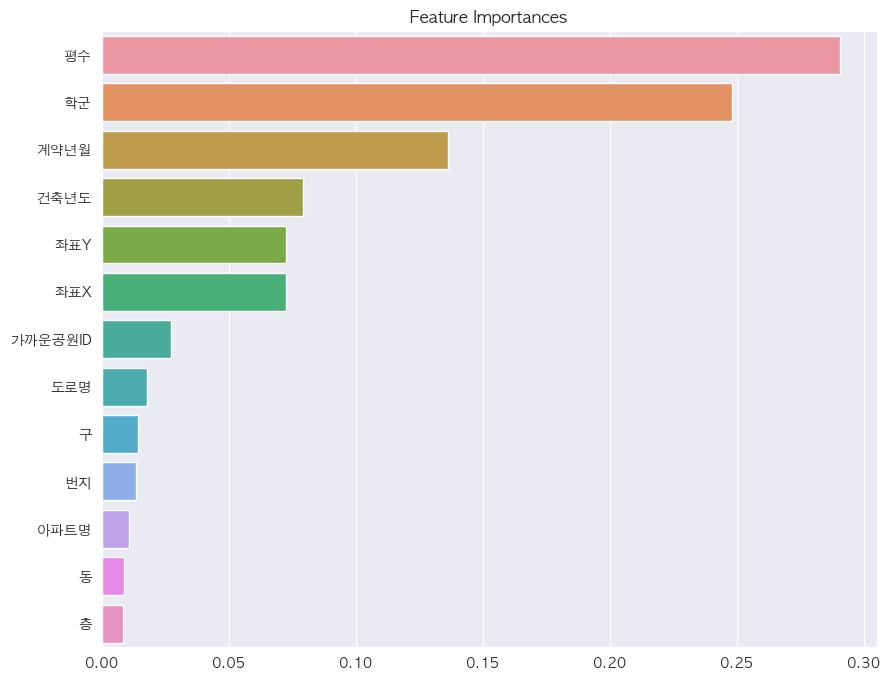

In [30]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

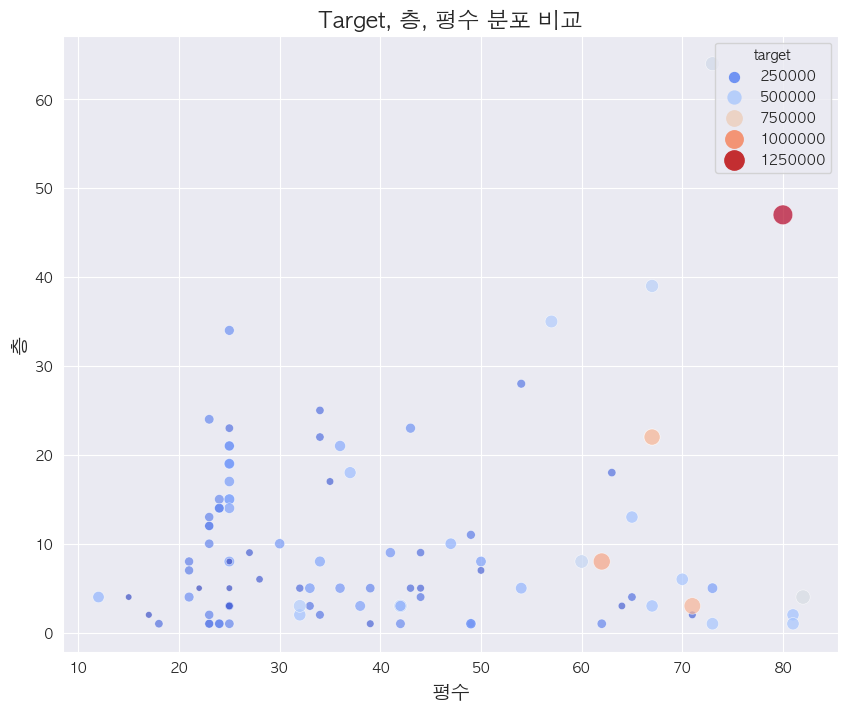

In [37]:
# 2D 히트맵으로 target, 층, 전용면적의 분포 비교
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=error_top100, 
    x='평수', 
    y='층', 
    size='target', 
    hue='target', 
    palette='coolwarm', 
    alpha=0.7, 
    sizes=(20, 200)
)
plt.title('Target, 층, 평수 분포 비교', fontsize=16)
plt.xlabel('평수', fontsize=14)
plt.ylabel('층', fontsize=14)
plt.legend(title='target')
plt.grid(True)
plt.show()

In [42]:
print(error_top100['층'].value_counts().sort_values(ascending=False))
print(error_top100['평수'].value_counts())

층
1     14
3     12
5     10
8      7
2      6
4      6
14     4
19     3
22     3
9      3
21     3
15     3
10     3
18     2
13     2
7      2
12     2
23     2
6      2
17     2
24     1
28     1
39     1
34     1
25     1
11     1
47     1
35     1
64     1
Name: count, dtype: int64
평수
25    19
23     8
24     6
67     4
34     4
49     4
32     3
21     3
44     3
42     3
73     3
50     2
33     2
71     2
36     2
62     2
39     2
81     2
54     2
43     2
65     2
63     1
37     1
35     1
15     1
28     1
30     1
38     1
17     1
12     1
82     1
41     1
47     1
22     1
70     1
80     1
27     1
57     1
64     1
60     1
18     1
Name: count, dtype: int64


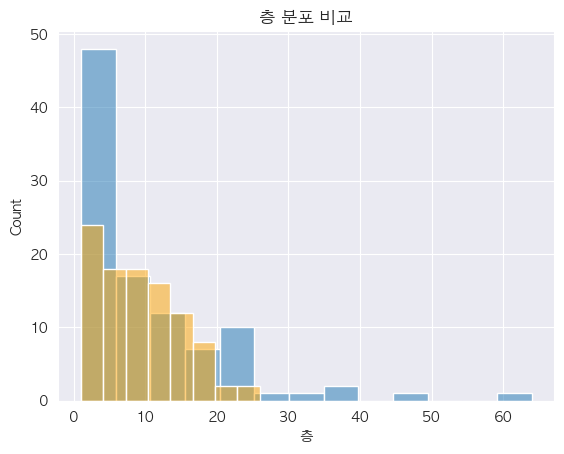

In [32]:
sns.histplot(data = error_top100, x='층', alpha=0.5)
sns.histplot(data = best_top100, x='층', color='orange', alpha=0.5)
plt.title('층 분포 비교')
plt.show()

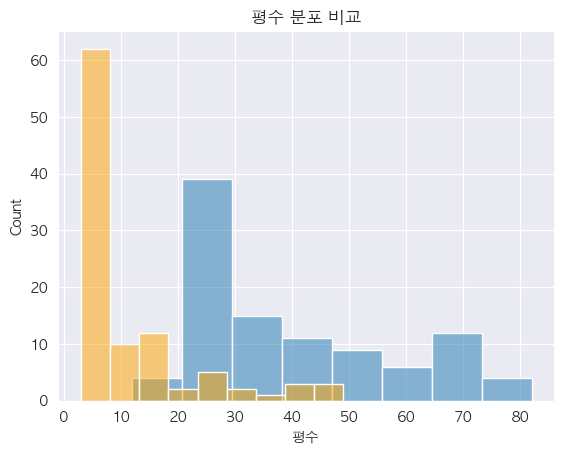

In [33]:
sns.histplot(data = error_top100, x='평수', alpha=0.5)
sns.histplot(data = best_top100, x='평수', color='orange', alpha=0.5)
plt.title('평수 분포 비교')
plt.show()

In [34]:
sns.histplot(data = error_top100, x='한강거리', alpha=0.5)
sns.histplot(data = best_top100, x='한강거리', color='orange', alpha=0.5)
plt.title('한강거리 분포 비교')
plt.show()

ValueError: Could not interpret value `한강거리` for parameter `x`

In [35]:
error_top100

,번지,아파트명,계약년월,층,건축년도,도로명,좌표X,좌표Y,평수,구,동,가까운공원ID,한강거리,학군,target,pred,예측차이,error
2201,1496-24,트라움하우스3,202212,4,2002,명달로 97-14,127.002921,37.486202,82,서초구,서초동,P02373,2892.877398,1,640000.0,260040.0,379960.0,1.443696e+11
3420,501,상봉듀오트리스,202301,37,2016,상봉로 131,127.092204,37.597362,61,중랑구,상봉동,P00566,4536.039315,0,185000.0,482800.0,-297800.0,8.868484e+10
4534,490,메세나폴리스,202209,39,2012,양화로 45,126.913938,37.551322,67,마포구,서교동,P01499,1214.605386,0,510000.0,723600.0,-213600.0,4.562496e+10
4881,685-700,아크로서울포레스트,202209,47,2020,왕십리로 83-21,127.043847,37.544464,80,성동구,성수동1가,P00357,1034.605382,0,1300000.0,1100000.0,200000.0,4.000000e+10
4810,612-28,비버리힐즈,202207,1,1998,사평대로12길 27,126.992966,37.496919,73,서초구,반포동,P02477,1533.015000,1,450000.0,251000.0,199000.0,3.960100e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3589,138,디에이치아너힐즈,202209,27,2019,삼성로 11,127.067960,37.484440,32,강남구,개포동,P02552,3952.168683,1,430000.0,348400.0,81600.0,6.658560e+09
2714,72-9,경덕,202212,6,2003,백제고분로32길 6-24,127.093807,37.502344,23,송파구,삼전동,P02663,2192.612995,1,51000.0,132400.0,-81400.0,6.625960e+09
2737,17,파크리오,202301,9,2008,올림픽로 435,127.106151,37.520537,25,송파구,신천동,P02701,1094.729863,1,170000.0,250000.0,-80000.0,6.400000e+09
481,441-3,정산,202301,5,2002,올림픽로104길 20,127.130718,37.555316,39,강동구,암사동,P02883,1089.118982,0,50000.0,130000.0,-80000.0,6.400000e+09


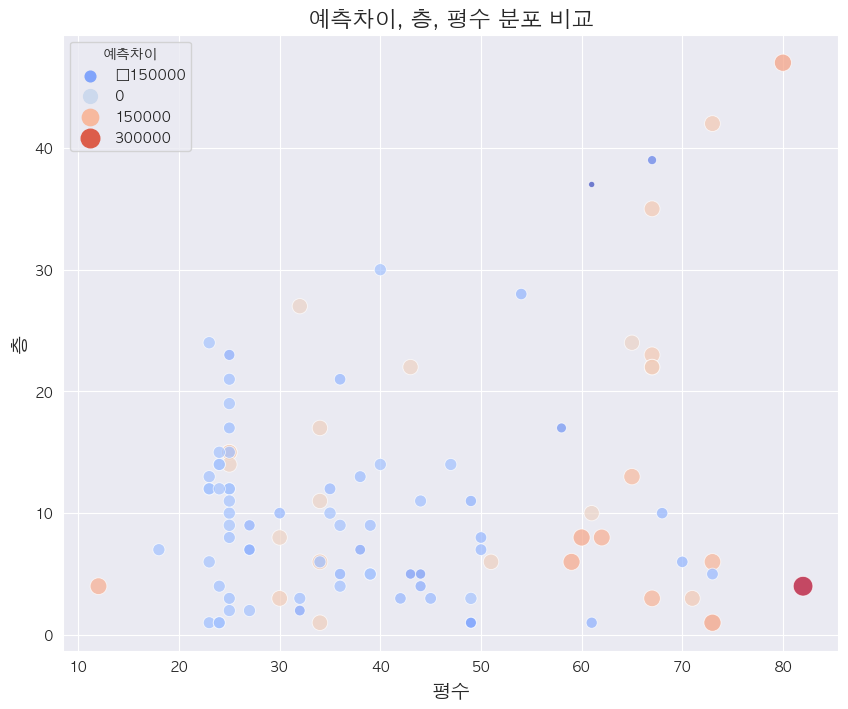

In [36]:

# 2D 히트맵으로 target, 층, 전용면적의 분포 비교
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=error_top100, 
    x='평수', 
    y='층', 
    size='예측차이', 
    hue='예측차이', 
    palette='coolwarm', 
    alpha=0.7, 
    sizes=(20, 200)
)
plt.title('예측차이, 층, 평수 분포 비교', fontsize=16)
plt.xlabel('평수', fontsize=14)
plt.ylabel('층', fontsize=14)
plt.legend(title='예측차이')
plt.grid(True)
plt.show()

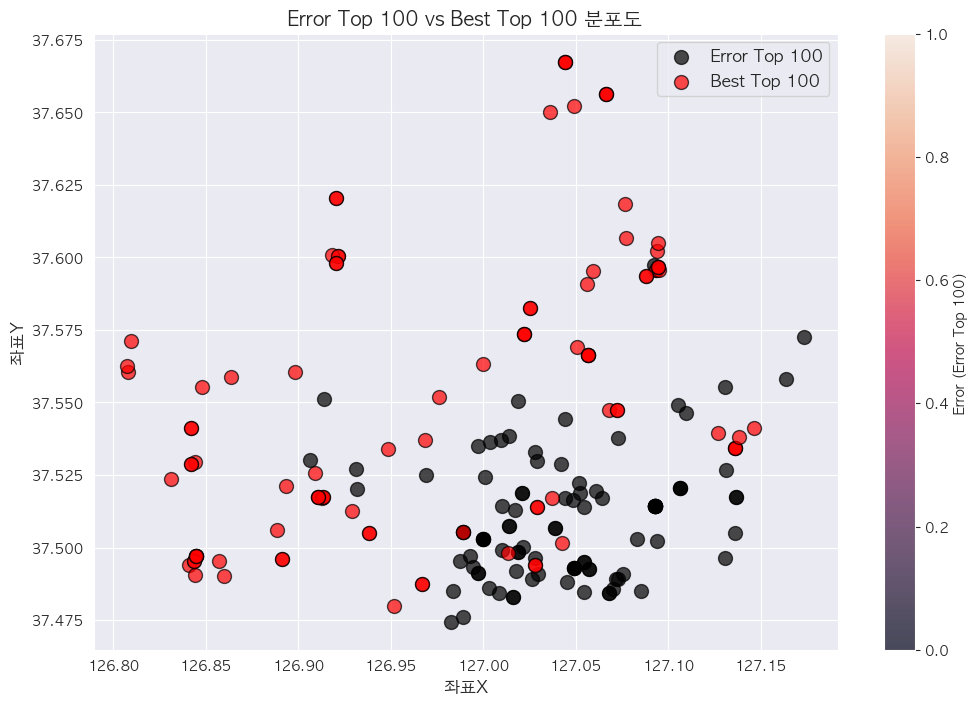

In [37]:

# 그래프 생성
plt.figure(figsize=(12, 8))

# error_top100 산점도
scatter1 = plt.scatter(
    error_top100['좌표X'], error_top100['좌표Y'], 
    c='black',  s=100, edgecolor='k', alpha=0.7, label='Error Top 100'
)

# best_top100 산점도
scatter2 = plt.scatter(
    best_top100['좌표X'], best_top100['좌표Y'], 
    c='red', s=100, edgecolor='k', alpha=0.7, label='Best Top 100'
)

# 컬러바 추가 (error_top100용)
plt.colorbar(scatter1, label='Error (Error Top 100)')

# 축 및 제목 설정
plt.xlabel('좌표X', fontsize=12)
plt.ylabel('좌표Y', fontsize=12)
plt.title('Error Top 100 vs Best Top 100 분포도', fontsize=14)
plt.grid(True)

# 범례 추가
plt.legend(fontsize=12)

# 그래프 표시
plt.show()

In [38]:
error_top100['구'].value_counts()

구
서초구     31
강남구     31
송파구     18
용산구      6
강동구      4
영등포구     3
광진구      3
성동구      2
중랑구      1
마포구      1
Name: count, dtype: int64

In [39]:
error_top100[error_top100['예측차이'] > 100000].value_counts()

번지       아파트명         계약년월    층   건축년도  도로명            좌표X         좌표Y        평수  구     동      가까운공원ID  한강거리         학군  target     pred       예측차이      error       
1-44     힐탑트레져1동      202301  3   2003  유엔빌리지길 200-16  127.013718  37.538466  67  용산구   한남동    P00198   796.385353   0   430000.0   264800.0   165200.0  2.729104e+10    1
1446-11  현대슈퍼빌        202207  23  2003  서초중앙로 15       127.016037  37.483010  67  서초구   서초동    P02366   3846.700998  1   363000.0   247400.0   115600.0  1.336336e+10    1
888      대치아이파크       202207  6   2008  선릉로 222        127.054583  37.494984  34  강남구   대치동    P02534   3297.414794  1   380000.0   274100.0   105900.0  1.121481e+10    1
847-34   방배대우유로카운티    202301  13  2002  방배로28길 90      126.996942  37.491138  65  서초구   방배동    P02486   2200.172067  1   430000.0   282200.0   147800.0  2.184484e+10    1
829      나인원한남        202211  8   2019  한남대로 91        127.003365  37.536254  62  용산구   한남동    P00235   1300.651674  0   945000.0   770000.0   175000.

In [40]:
error_top100.columns

Index(['번지', '아파트명', '계약년월', '층', '건축년도', '도로명', '좌표X', '좌표Y', '평수', '구', '동',
       '가까운공원ID', '한강거리', '학군', 'target', 'pred', '예측차이', 'error'],
      dtype='object')

In [41]:
dd = df.query('is_test == 0')

In [42]:
dd[dd['아파트명'] == '힐탑트레져1동'][['번지', '아파트명', '계약년월', '층', '건축년도', '도로명', '좌표X', '좌표Y', '평수', '구', '동',
       '가까운공원ID', '한강거리', 'target']]

,번지,아파트명,계약년월,층,건축년도,도로명,좌표X,좌표Y,평수,구,동,가까운공원ID,한강거리,target
88092,1-44,힐탑트레져1동,201712,9,2003,유엔빌리지길 200-16,127.013718,37.538466,55,용산구,한남동,P00198,796.385353,245000.0
88093,1-44,힐탑트레져1동,201803,7,2003,유엔빌리지길 200-16,127.013718,37.538466,62,용산구,한남동,P00198,796.385353,260000.0
132300,1-44,힐탑트레져1동,201112,1,2003,유엔빌리지길 200-16,127.013718,37.538466,64,용산구,한남동,P00198,796.385353,200000.0
197557,1-44,힐탑트레져1동,200811,9,2003,유엔빌리지길 200-16,127.013718,37.538466,63,용산구,한남동,P00198,796.385353,210000.0
197558,1-44,힐탑트레져1동,200901,8,2003,유엔빌리지길 200-16,127.013718,37.538466,63,용산구,한남동,P00198,796.385353,201000.0
197559,1-44,힐탑트레져1동,200904,11,2003,유엔빌리지길 200-16,127.013718,37.538466,69,용산구,한남동,P00198,796.385353,280000.0
197560,1-44,힐탑트레져1동,200909,4,2003,유엔빌리지길 200-16,127.013718,37.538466,63,용산구,한남동,P00198,796.385353,245000.0
197561,1-44,힐탑트레져1동,200909,10,2003,유엔빌리지길 200-16,127.013718,37.538466,63,용산구,한남동,P00198,796.385353,275000.0
267733,1-44,힐탑트레져1동,202010,3,2003,유엔빌리지길 200-16,127.013718,37.538466,69,용산구,한남동,P00198,796.385353,304000.0
267734,1-44,힐탑트레져1동,202010,9,2003,유엔빌리지길 200-16,127.013718,37.538466,69,용산구,한남동,P00198,796.385353,338000.0
